In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

In [68]:
mpl.rcParams['figure.figsize'] = (20,10)

In [69]:
df1 = pd.read_csv('C:\\Users\\OfoghPC 32241004\\Downloads\\bengaluru_house_prices.csv')
df1['price'] = df1['price'].apply(lambda x: int(x*1200))

In [70]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [71]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')

In [72]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [73]:
df3 = df2.dropna()

In [74]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [75]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\OfoghPC 32241004\AppData\Local\Temp\ipykernel_4684\2222900254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [76]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [77]:
df3[~df3['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,223200,4
122,Hebbal,4 BHK,3067 - 8156,4.0,572400,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,64806,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,52188,2
188,KR Puram,2 BHK,1015 - 1540,2.0,68160,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,45828,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,146400,3
13059,Harlur,2 BHK,1200 - 1470,2.0,87312,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,70962,2


In [78]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [79]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)

In [80]:
df4['total_area'] = df4['total_sqft'].apply(lambda x: float(x*0.093))

In [81]:
df4 = df4.drop('total_sqft', axis='columns')

In [82]:
df4['price_per_sqm'] = df4['price']/df4['total_area']

In [83]:
len(df4.location.unique())

1304

In [84]:
df4.location = df4.location.apply(lambda x: x.strip())
location_stats = df4.groupby('location')['location'].agg('count').sort_values(ascending=False)

In [85]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [86]:
df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [87]:
df4[df4.total_area/df4.bhk<27.87].head()

,location,size,bath,price,bhk,total_area,price_per_sqm
9,other,6 Bedroom,6.0,444000,6,94.860,4680.581910
45,HSR Layout,8 Bedroom,9.0,240000,8,55.800,4301.075269
58,Murugeshpalya,6 Bedroom,4.0,180000,6,130.851,1375.610427
68,Devarachikkanahalli,8 Bedroom,7.0,102000,8,125.550,812.425329
70,other,3 Bedroom,3.0,120000,3,46.500,2580.645161


In [88]:
df5 = df4[~(df4.total_area/df4.bhk<27.87)]

In [89]:
def remove_pps_outlier(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqm)
        st = np.std(subdf.price_per_sqm)
        reduced_df = subdf[(subdf.price_per_sqm>(m-st)) & (subdf.price_per_sqm<=(m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

In [90]:
df6 = remove_pps_outlier(df5)
df6.shape

(10242, 7)

In [91]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    mpl.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_area, bhk2.price_per_sqm, color='b', label='2 bhk', s=50)
    plt.scatter(bhk3.total_area, bhk3.price_per_sqm, marker='+', color='g', label='3 bhk', s=50)
    plt.xlabel('total square meter area')
    plt.ylabel('price per square meter')
    plt.title(location)
    plt.legend()

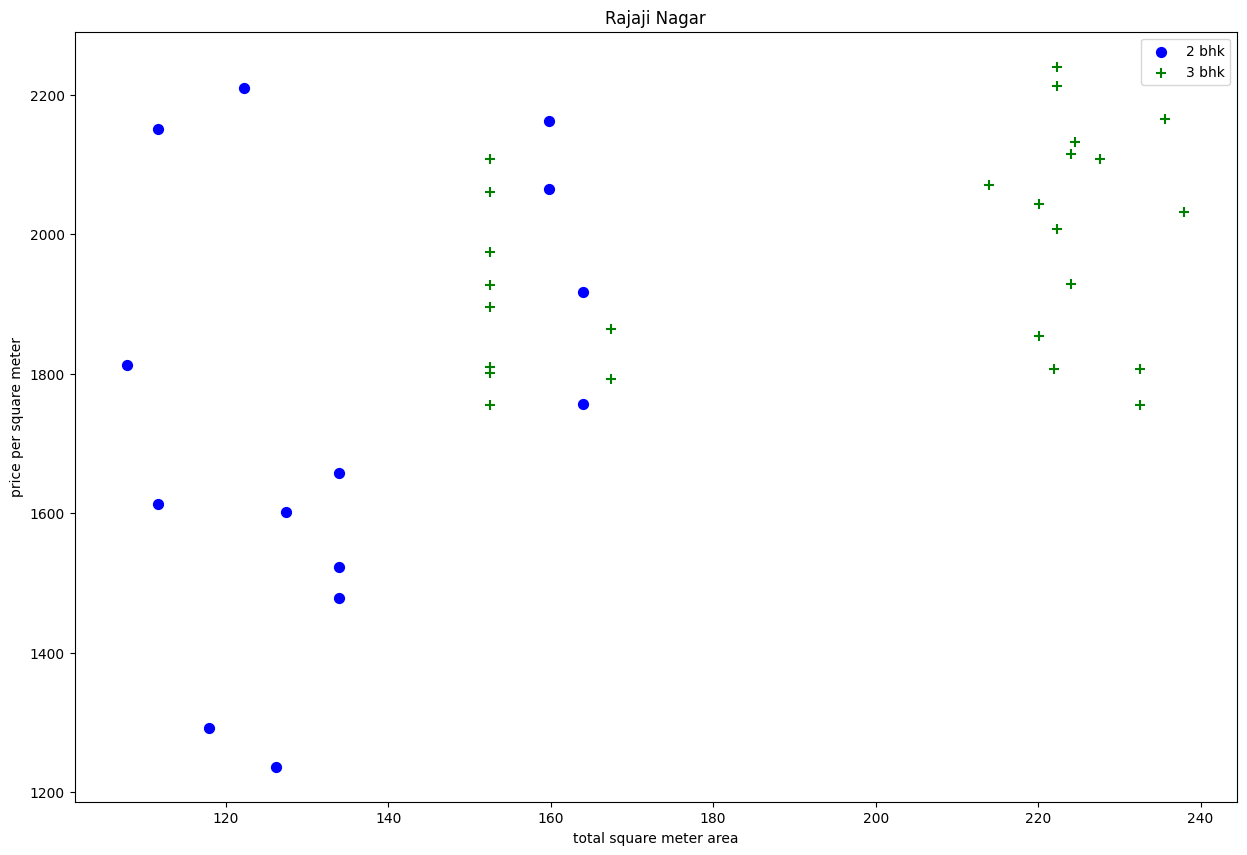

In [92]:
plot_scatter_chart(df7,'Rajaji Nagar')

In [93]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats= {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqm),
                'std': np.std(bhk_df.price_per_sqm),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqm<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [94]:
df7 = remove_bhk_outliers(df6)

Text(0, 0.5, 'count')

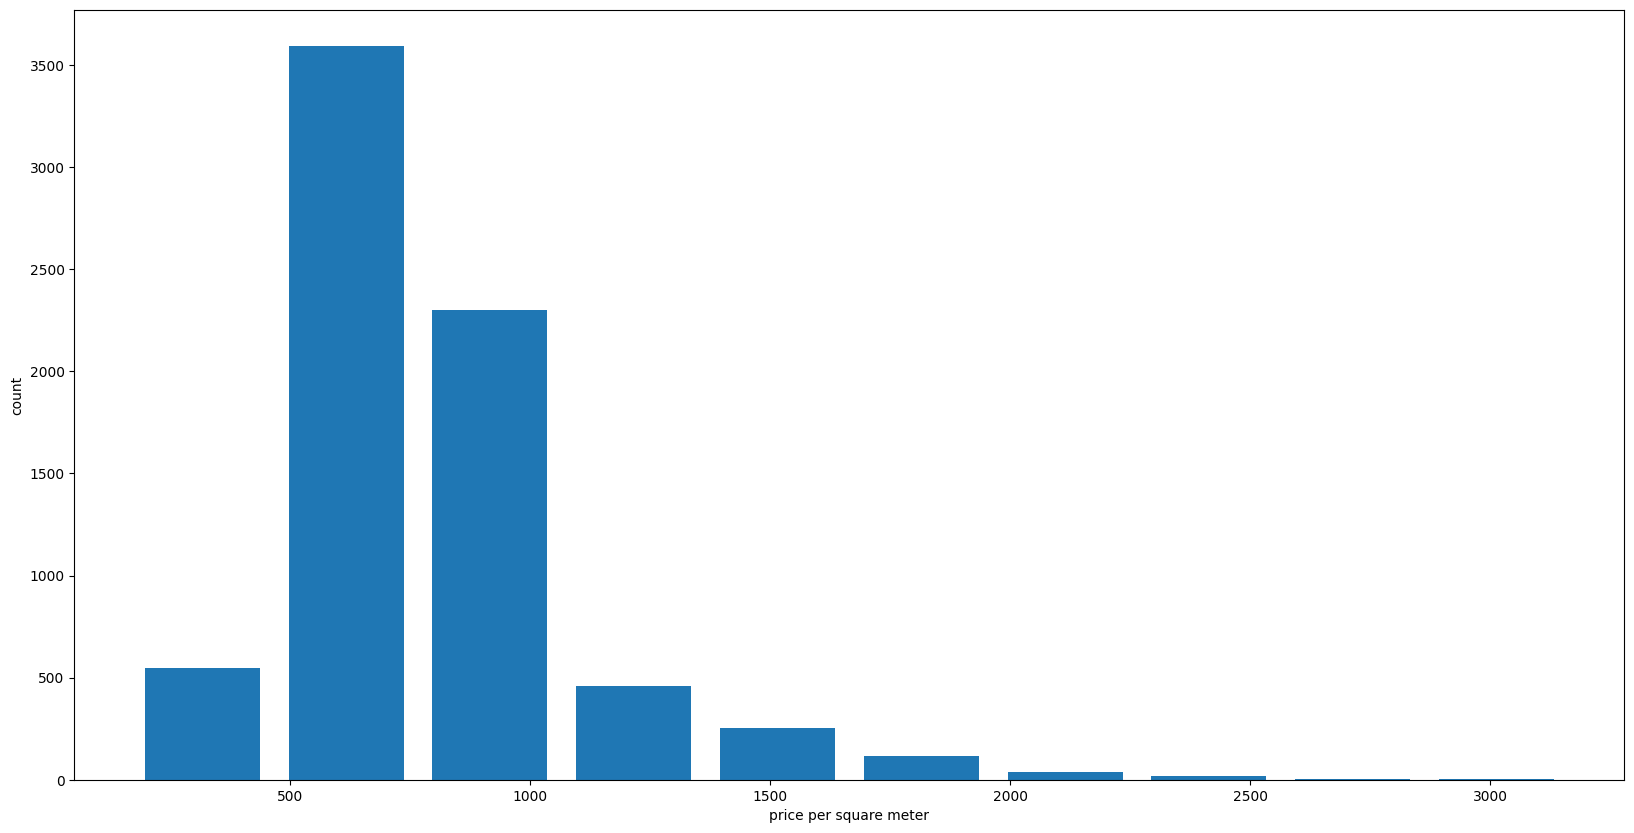

In [95]:
mpl.rcParams['figure.figsize'] = (20,10)
plt.hist(df7.price_per_sqm, rwidth=0.8)
plt.xlabel('price per square meter')
plt.ylabel('count')

(array([4.766e+03, 1.763e+03, 6.780e+02, 8.100e+01, 2.900e+01, 7.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

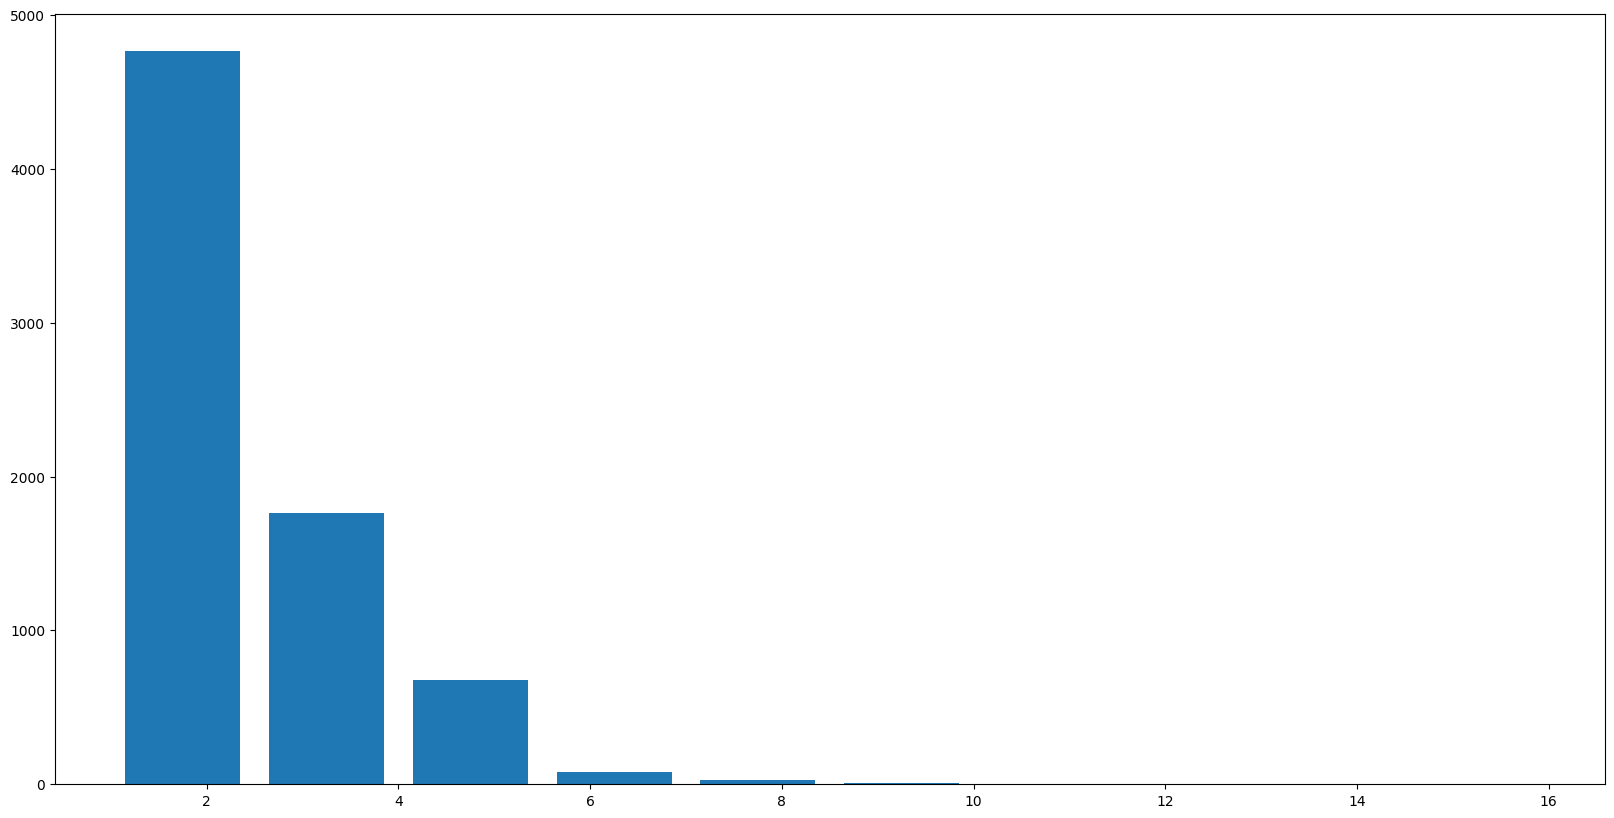

In [96]:
plt.hist(df7.bath, rwidth=0.8)


In [97]:
df8 = df7[df7.bath<df7.bhk+2]

In [98]:
df9 = df8.drop(['size','price_per_sqm'], axis='columns')

In [99]:
dummies = pd.get_dummies(df9.location)

In [100]:
df10 = pd.concat([df9,dummies.drop('other', axis='columns')], axis='columns')

In [101]:
df11 = df10.drop('location', axis='columns')

In [102]:
x= df11.drop('price', axis='columns')
y= df11['price']

In [103]:
from sklearn.model_selection import train_test_split as tts
x_train , x_test , y_train , y_test = tts(x, y, test_size=0.2, random_state=10)

In [104]:
from sklearn.linear_model import LinearRegression as lr
lr_clf = lr()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.8452277729330553

In [105]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(lr(), x, y, cv=cv)

array([0.82430188, 0.77166236, 0.85089567, 0.80837767, 0.83653287])

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [107]:
def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model': lr(),
            'params':{
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model','best_score','best_params'])

In [108]:
find_best_model_using_gridsearchcv(x,y)

c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\program files\python38\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\program files\python38\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\program files\python38\lib\site-pack

,model,best_score,best_params
0,linear_regression,0.819001,{'fit_intercept': False}
1,lasso,0.818347,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.708634,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [114]:
def pridict_price(location,sqm,bath,bhk):
    loc_index = np.where(x.columns==location)[0][0]
    t = np.zeros(len(x.columns))
    t[0] = sqm
    t[1] = bath
    t[2] = bhk
    if loc_index >=0:
        t[loc_index] = 1
    return lr_clf.predict([t])[0]

In [115]:
pridict_price('1st Phase JP Nagar',92.9, 2, 2)

c:\program files\python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


560969.826879201

In [116]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf,f)

In [118]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))